In [1]:
import pandas as pd
import numpy as np
from os import listdir
from os.path import isfile, join
from lxml import etree
import re
import matplotlib.pyplot as plt

from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt
from sklearn.utils.fixes import signature
from sklearn.metrics import average_precision_score
from matplotlib import pyplot
from statsmodels.graphics.gofplots import qqplot

from numpy import mean
from numpy import std
from scipy.stats import shapiro, mannwhitneyu

In [2]:
import plotly
import plotly.graph_objs as go
from scipy import stats

plotly.offline.init_notebook_mode(connected=True)

In [3]:
def MannWhit(title,data1,data2):
    print(title)
    
    stat, p = mannwhitneyu(data1, data2,alternative="two-sided")
    print('Statistics=%.3f, p=%.3f' % (stat, p))
    # interpret
    alpha = 0.05
    if p > alpha:
        print('Same distribution (fail to reject H0)')
    else:
        print('Different distribution (reject H0)')

In [4]:
def parseXML(file,test):
    """
    Parse the xml
    """
    label_dir=""
    
    xmlFile=join(label_dir,file)
    
    if not isfile(xmlFile):
        ## File Does not exit return null ground-truth bo
        print("file does not exist "+xmlFile)
        return []    
    gt_box=[]
    with open(xmlFile) as fobj:
        xml = fobj.read()
    
    fileid=file.split(".")[0]

    root = etree.fromstring(xml)

    for appt in root.getchildren():
        for elem in appt.getchildren():
            #if elem.tag == "name":
            #    print(elem.text)
            if elem.tag == "bndbox":
                for bb in elem.getchildren():
                    if not bb.text:
                        text = "None"
                    else:
                        if bb.tag=="xmin": xn=int(bb.text)
                        if bb.tag=="ymin": yn=int(bb.text)
                        if bb.tag=="xmax": xx=int(bb.text)
                        if bb.tag=="ymax": yx=int(bb.text)
                gt_box.append([test,fileid,xn,yn,xx,yx])
    return gt_box

In [5]:
def showhistogram(dataframe,plot_title):
    
    trace1=go.Histogram(x=dataframe.width,
                            name='Bounding Box width',
                            xbins=dict(start=0,end=200,size=10),
                            marker=dict(color='#FFD7E9',line=dict(color='rgb(8,48,107)',width=1.5),),
                            opacity=1,
                            xaxis='x1')
    
    trace2=go.Histogram(x=dataframe.height,
                        name='Bounding Box height',
                        xbins=dict(start=0,end=200,size=10),
                        marker=dict(color='#22D7FF',line=dict(color='rgb(8,48,107)',width=1.5),),
                        opacity=1,
                        xaxis='x2')
       

    data = [trace1, trace2]
    layout = go.Layout(
        title=plot_title,
        xaxis=dict(
            zeroline=True,
            autorange=True,
            rangemode="tozero",
            domain=[0, 0.475],
            anchor='x1'
        ),
        xaxis2=dict(
            zeroline=True,
            autorange=True,
            rangemode="tozero",
            domain=[0.525, 1],
            anchor='x2'
        )
        
    )
    fig = go.Figure(data=data, layout=layout)
    plotly.offline.iplot(fig, filename='side-by-side-subplot')

In [6]:
def showhist(plot_title,data_1):
    
    data = np.log(data_1)
    minimum = min(data)
    maximum = max(data)
    sizedat=(maximum-minimum)/20
    
    trace1=go.Histogram(x=data,
                            name='Log Aspect Ratio W/H',
                            xbins=dict(start=minimum,end=maximum,size=sizedat),
                            marker=dict(color='#D7FFE9',line=dict(color='rgb(8,48,107)',width=1.5),),
                            opacity=1)

    data = [trace1]
    layout = go.Layout(
        title=plot_title,
    )
    fig = go.Figure(data=data, layout=layout)
    plotly.offline.iplot(fig, filename='side-by-side-subplot')

In [7]:
def xml_from_dir(test):
    
    if test=="geo":
        label_dir="/part/data/upairtest_geo/label/"
    elif test=="train":
        label_dir="/part/data/upairtag/label/"
    elif test=="test":
        label_dir="/part/data/upairtest/label/"
    
    xml_files = [join(label_dir,f) for f in listdir(label_dir) if isfile(join(label_dir, f))]
    boxlist=[]
    for xml_file in xml_files:
        boxlist_set=parseXML(xml_file,test)
        for gt in boxlist_set:
            boxlist.append(gt)
            
    
    dataframe = pd.DataFrame(boxlist)
    
    dataframe.columns = ['dataset','filename','x','y','x1','y1']
    dataframe['width'] = dataframe.x1-dataframe.x
    dataframe['height'] = dataframe.y1 - dataframe.y
    dataframe['aspect'] = dataframe['width']/dataframe['height']
    
    #df = df.drop(df[df.score < 50].index)
    dataframe = dataframe.drop(dataframe[dataframe.width<10].index)
    dataframe = dataframe.drop(dataframe[dataframe.height<10].index)
    
    return dataframe

In [8]:
def showqqplot(dataframe,plot_title):
    # summarize
    print('Width Stats: mean=%.3f stdv=%.3f' % (mean(dataframe.width), std(dataframe.width)))
    print('Height Stats: mean=%.3f stdv=%.3f' % (mean(dataframe.height), std(dataframe.height)))
    print('Minimum\Maximum Width: min=%.3f max=%.3f' % (min(dataframe.width), max(dataframe.width)))
    print('Minimum\Maximum Height: min=%.3f max=%.3f' % (min(dataframe.height), max(dataframe.height)))
    
    plt.figure(num=None, figsize=(12, 5), dpi=80, facecolor='w', edgecolor='k')
    plt.subplot(1, 2, 1)
    stats.probplot(dataframe.width, dist="norm", plot=plt)
    plt.title("Width QQPlot")
    
    plt.subplot(1, 2, 2)
    stats.probplot(dataframe.height, dist="norm", plot=plt)
    plt.title("Height QQPlot")
    plt.show()
    
    stat, p = shapiro(dataframe.width)
    print('Width Statistics=%.3f, p=%.3f' % (stat, p))
    # interpret
    alpha = 0.05
    if p > alpha:
        print('Width sample looks Gaussian (fail to reject H0)')
    else:
        print('Width sample does not look Gaussian (reject H0)')
        
    stat, p = shapiro(dataframe.height)
    print('\nHeight Statistics=%.3f, p=%.3f' % (stat, p))
    # interpret
    alpha = 0.05
    if p > alpha:
        print('Height sample looks Gaussian (fail to reject H0)')
    else:
        print('Height sample does not look Gaussian (reject H0)')

Width Stats: mean=36.038 stdv=11.921
Height Stats: mean=37.318 stdv=10.420
Minimum\Maximum Width: min=11.000 max=120.000
Minimum\Maximum Height: min=10.000 max=82.000


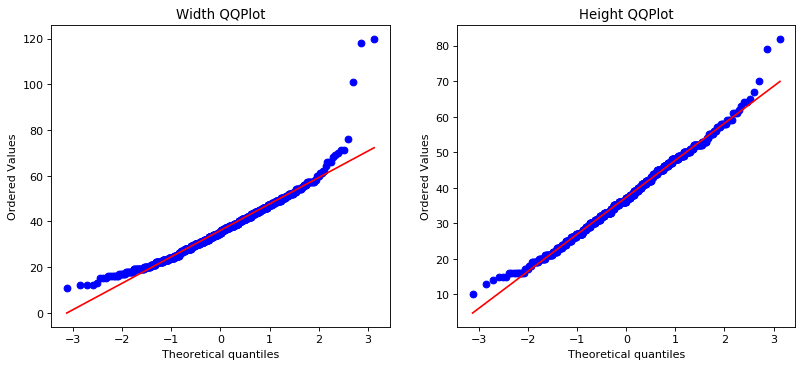

Width Statistics=0.936, p=0.000
Width sample does not look Gaussian (reject H0)

Height Statistics=0.992, p=0.000
Height sample does not look Gaussian (reject H0)


In [9]:
geo_df = xml_from_dir("geo")
showhistogram(geo_df,"GeoScience Funded Land Survey Drone Bounding Box Size - Histogram")
showqqplot(geo_df,"GeoScience Funded Land Survey Drone Bounding Box Size - QQPlot")
showhist("GeoScience Land Survey Bounding Box Log Aspect Ratio Width/Height",geo_df.aspect)

Width Stats: mean=71.654 stdv=29.453
Height Stats: mean=81.232 stdv=34.203
Minimum\Maximum Width: min=26.000 max=199.000
Minimum\Maximum Height: min=30.000 max=272.000


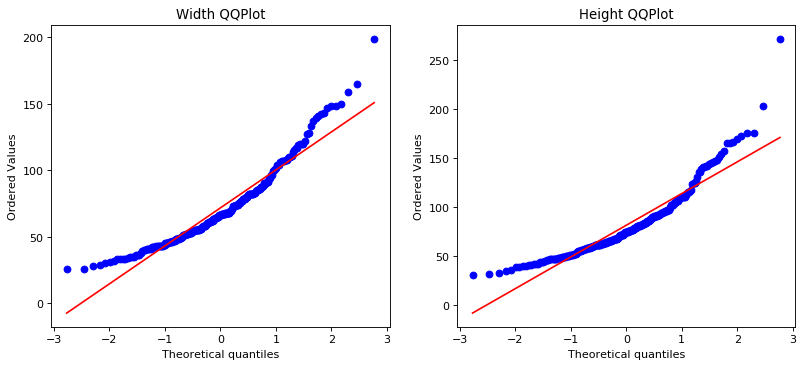

Width Statistics=0.924, p=0.000
Width sample does not look Gaussian (reject H0)

Height Statistics=0.883, p=0.000
Height sample does not look Gaussian (reject H0)


In [10]:
test_df = xml_from_dir("test")
showhistogram(test_df , "Consumer Drone Bounding Box Size - Testing Dataset")
showqqplot(test_df , "Consumer Drone Bounding Box Size - QQPlot")
showhist("Consumer Drone Bounding Box Log Aspect Ratio Width/Height (Test)",test_df.aspect)

Width Stats: mean=74.130 stdv=28.043
Height Stats: mean=79.565 stdv=26.888
Minimum\Maximum Width: min=25.000 max=206.000
Minimum\Maximum Height: min=31.000 max=207.000


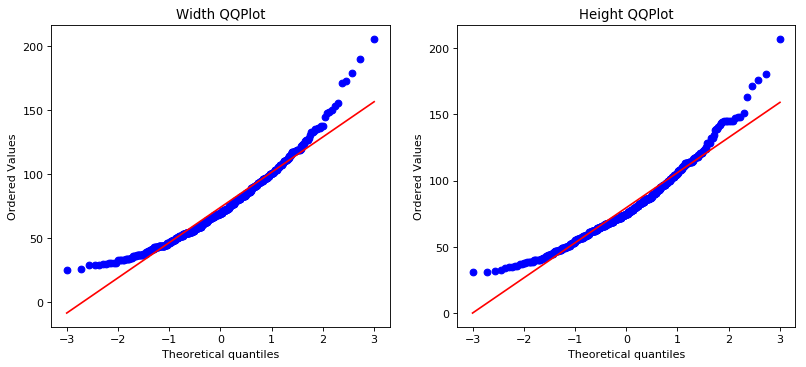

Width Statistics=0.949, p=0.000
Width sample does not look Gaussian (reject H0)

Height Statistics=0.954, p=0.000
Height sample does not look Gaussian (reject H0)


In [11]:
train_df = xml_from_dir("train")
showhistogram(train_df,"Consumer Drone Bounding Box Size - Training Dataset")
showqqplot(train_df,"Consumer Drone Bounding Box Size - QQPlot")
showhist("Consumer Drone Bounding Box Log Aspect Ratio Width/Height (Train)",train_df.aspect)

#### Test if Distributions Height and Width of Bounding Boxes
#### Between Train and Test Data from 
#### Consumer Drone are from the same Population

In [12]:
MannWhit("Consumer Drone Comparison Train to Test Width", np.array(train_df.width), np.array(test_df.width ))

Consumer Drone Comparison Train to Test Width
Statistics=69299.000, p=0.092
Same distribution (fail to reject H0)


In [13]:
MannWhit("Consumer Drone Comparison Train to Test Height", np.array(train_df.height), np.array(test_df.height ))

Consumer Drone Comparison Train to Test Height
Statistics=66246.500, p=0.533
Same distribution (fail to reject H0)


#### Test if Distributions for Height and Width of Bounding Boxes 
#### Between Train Data from Consumer Drone and 
####  GeoScience Drone  Data from 
#### are from the same Population

In [14]:
MannWhit("Consumer Drone to GeoSciences Drone Comparison Width", np.array(train_df.width), np.array(geo_df.width ))

Consumer Drone to GeoSciences Drone Comparison Width
Statistics=383029.000, p=0.000
Different distribution (reject H0)


In [16]:
MannWhit("Consumer Drone to GeoSciences Drone Comparison Height", np.array(train_df.height), np.array(geo_df.height ))

Consumer Drone to GeoSciences Drone Comparison Height
Statistics=396711.000, p=0.000
Different distribution (reject H0)


In [20]:
len(train_df)

524